<a href="https://colab.research.google.com/github/antonioalbanese/Time-Series-Anomaly-Detection-An-experimental-survey/blob/main/Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pytorch_lightning torchinfo --quiet

     |████████████████████████████████| 708 kB 13.4 MB/s 
     |████████████████████████████████| 529 kB 60.3 MB/s 


In [3]:
!git clone https://github.com/antonioalbanese/Time-Series-Anomaly-Detection-An-experimental-survey/

%cd Time-Series-Anomaly-Detection-An-experimental-survey

%mkdir dataset
!gdown https://drive.google.com/uc?id=1ZCLBU_pKTbsPlcj_LwxZE3IRy6mrlys3 -O="./dataset/MSL.zip"
import zipfile
with zipfile.ZipFile("./dataset/MSL.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset/")

Cloning into 'Time-Series-Anomaly-Detection-An-experimental-survey'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 159 (delta 31), reused 118 (delta 20), pack-reused 17
Receiving objects: 100% (159/159), 2.25 MiB | 802.00 KiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/Time-Series-Anomaly-Detection-An-experimental-survey
Downloading...
From: https://drive.google.com/uc?id=1ZCLBU_pKTbsPlcj_LwxZE3IRy6mrlys3
To: /content/Time-Series-Anomaly-Detection-An-experimental-survey/dataset/MSL.zip
100% 767k/767k [00:00<00:00, 127MB/s]


In [2]:
from AnomalyDetectionMethodClass import ADMethod
data_path = './dataset/MSL'
settings = {
    'lr':1e-4,
    'num_epochs':3,
    'k':3,
    'win_size':100,
    'input_c':55,
    'output_c':55,
    'batch_size':256,
    'pretrained_model':None,
    'dataset':'MSL',
    'mode':'train', # choices=['train', 'test']
    'data_path':'./dataset/MSL',
    'model_save_path':'checkpoints',
    'anormly_ratio':1
}
method = ADMethod('transformer',settings, data_path)

In [3]:
method.prepare_pipeline()
method.train()
method.test()
method.results()

test: (73729, 55)
train: (58317, 55)
test: (73729, 55)
train: (58317, 55)
test: (73729, 55)
train: (58317, 55)
test: (73729, 55)
train: (58317, 55)
======================TRAIN MODE======================
	speed: 0.8180s/iter; left time: 478.5215s
	speed: 0.7547s/iter; left time: 366.0355s
Epoch: 1 cost time: 178.35229921340942
Epoch: 1, Steps: 228 | Train Loss: -41.9398839 Vali Loss: -44.9924650 
Validation loss decreased (inf --> -44.992465).  Saving model ...
Updating learning rate to 0.0001
	speed: 1.5929s/iter; left time: 568.6633s
	speed: 0.7542s/iter; left time: 193.8339s
Epoch: 2 cost time: 171.64147114753723
Epoch: 2, Steps: 228 | Train Loss: -47.0828519 Vali Loss: -45.9290438 
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
	speed: 1.5907s/iter; left time: 205.2040s
	speed: 0.7547s/iter; left time: 21.8872s
Epoch: 3 cost time: 171.46167659759521
Epoch: 3, Steps: 228 | Train Loss: -47.7037282 Vali Loss: -46.1303732 
EarlyStopping counter: 2 out of 3
Updating le

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Threshold : 0.007498042606748454
pred:    (73700,)
gt:      (73700,)
pred:  (73700,)
gt:    (73700,)
Accuracy : 0.9857, Precision : 0.9193, Recall : 0.9473, F-score : 0.9331 


In [4]:
import pandas as pd
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from torchinfo import summary

from DeepAnt.deepant import AnomalyDetector, DataModule, TrafficDataset, DeepAnt

from DeepAnt.utils import plot_predictions, loss_plot, ts_plot

pl.seed_everything(42, workers=True)


if not torch.cuda.is_available():
    print('Please Activate GPU Accelerator if available')
else:
    print('Everything is Set')

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Everything is Set


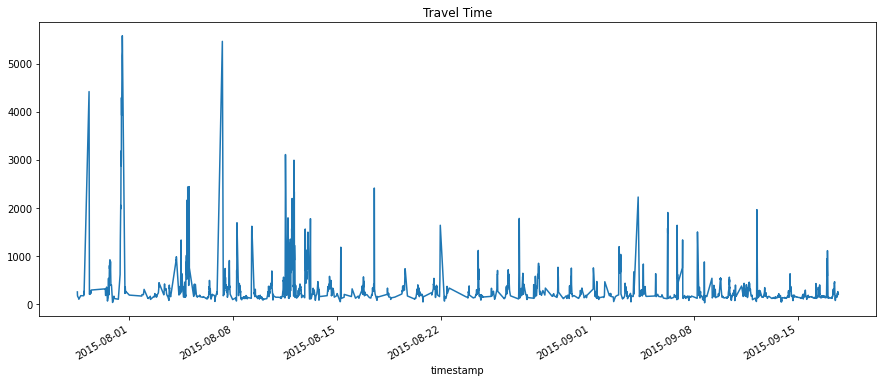

In [5]:
df = pd.read_csv('DeepAnt/data/TravelTime_451.csv', index_col = 'timestamp', parse_dates=['timestamp'])
df.plot(figsize = (15, 6), title = 'Travel Time', legend = False);

In [7]:
SEQ_LEN = 10
dataset = TrafficDataset(df, SEQ_LEN)
target_idx = dataset.timestamp # Timestamps to detect where the Anomaly Happens
X, y = dataset[0]
X.shape, y.shape, len(dataset) # Checking Sizes are compatible...

model = DeepAnt(SEQ_LEN, 1)
sample = torch.randn(32,1,10)

model(sample).shape

torch.Size([32, 1])

In [8]:
model = DeepAnt(SEQ_LEN, 1)
anomaly_detector = AnomalyDetector(model)
dm = DataModule(df, SEQ_LEN)
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'train_loss', 
    mode = 'min'
    )

mc.CHECKPOINT_NAME_LAST = f'DeepAnt-best-checkpoint'
summary(model)

Layer (type:depth-idx)                   Param #
DeepAnt                                  --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       128
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-4                       3,104
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
├─Flatten: 1-3                           --
├─Sequential: 1-4                        --
│    └─Linear: 2-7                       1,320
│    └─ReLU: 2-8                         --
│    └─Dropout: 2-9                      --
├─Linear: 1-5                            41
Total params: 4,593
Trainable params: 4,593
Non-trainable params: 0

In [9]:
trainer = pl.Trainer(max_epochs=30,
                    accelerator="gpu",
                    devices=1, 
                    callbacks=[mc], 
                    #progress_bar_refresh_rate=30, 
                    #fast_dev_run=True,
                    #overfit_batches=1
                    )
trainer.fit(anomaly_detector, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params
--------------------------------------
0 | model     | DeepAnt | 4.6 K 
1 | criterion | L1Loss  | 0     
--------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this D

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 68: 'train_loss' reached 0.09627 (best 0.09627), saving model to '/content/Time-Series-Anomaly-Detection-An-experimental-survey/checkpoints/epoch=0-step=68.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 136: 'train_loss' reached 0.06732 (best 0.06732), saving model to '/content/Time-Series-Anomaly-Detection-An-experimental-survey/checkpoints/epoch=1-step=136.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 204: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 272: 'train_loss' reached 0.06699 (best 0.06699), saving model to '/content/Time-Series-Anomaly-Detection-An-experimental-survey/checkpoints/epoch=3-step=272.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 340: 'train_loss' reached 0.04623 (best 0.04623), saving model to '/content/Time-Series-Anomaly-Detection-An-experimental-survey

In [10]:
anomaly_detector = AnomalyDetector.load_from_checkpoint('checkpoints/DeepAnt-best-checkpoint.ckpt',
                                model = model)

In [12]:
output = trainer.predict(anomaly_detector, dm)
preds_losses = pd.Series(torch.tensor([item[1] for item in output]).numpy(), index = target_idx)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 68it [00:00, ?it/s]

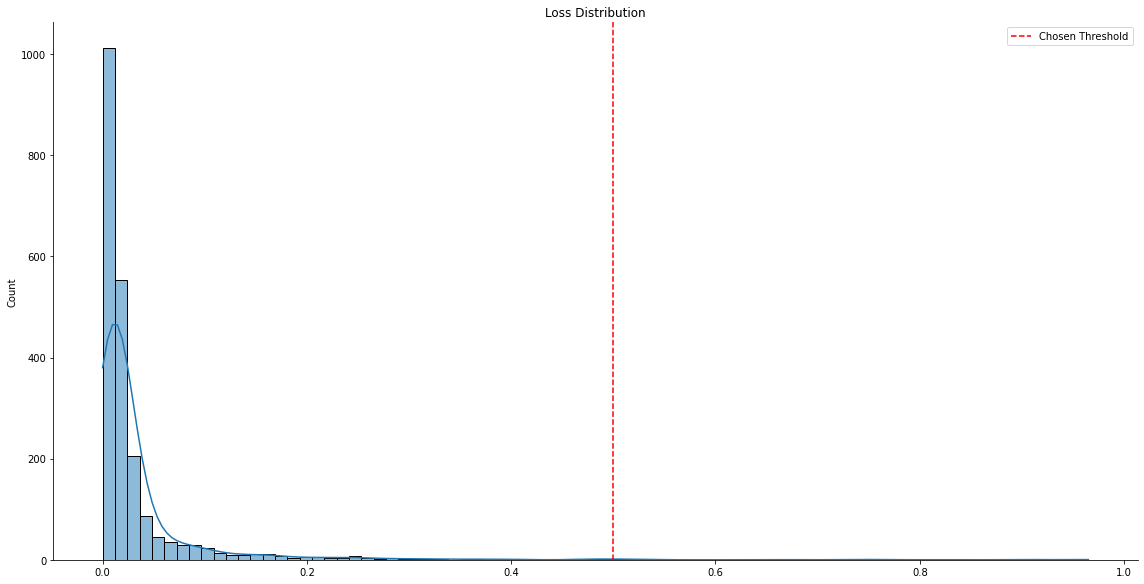

In [13]:
THRESHOLD = 0.5    
plot_predictions(preds_losses, THRESHOLD)

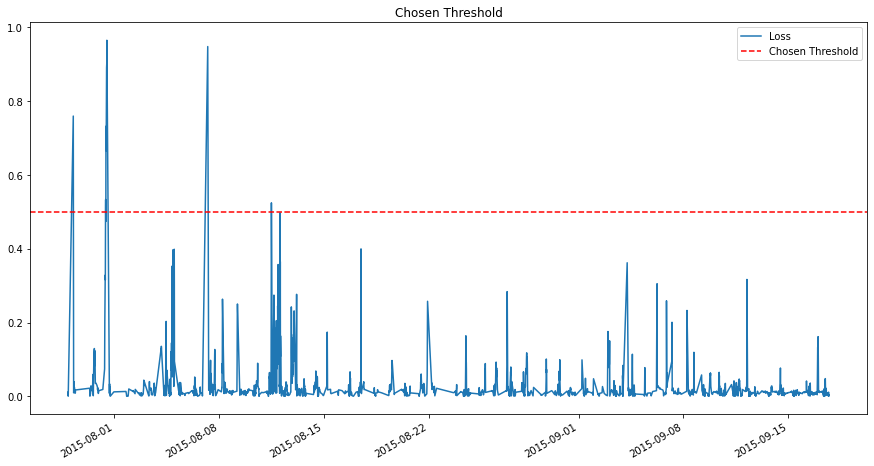

In [14]:
loss_plot(preds_losses, THRESHOLD)

Anomalies Detected: 


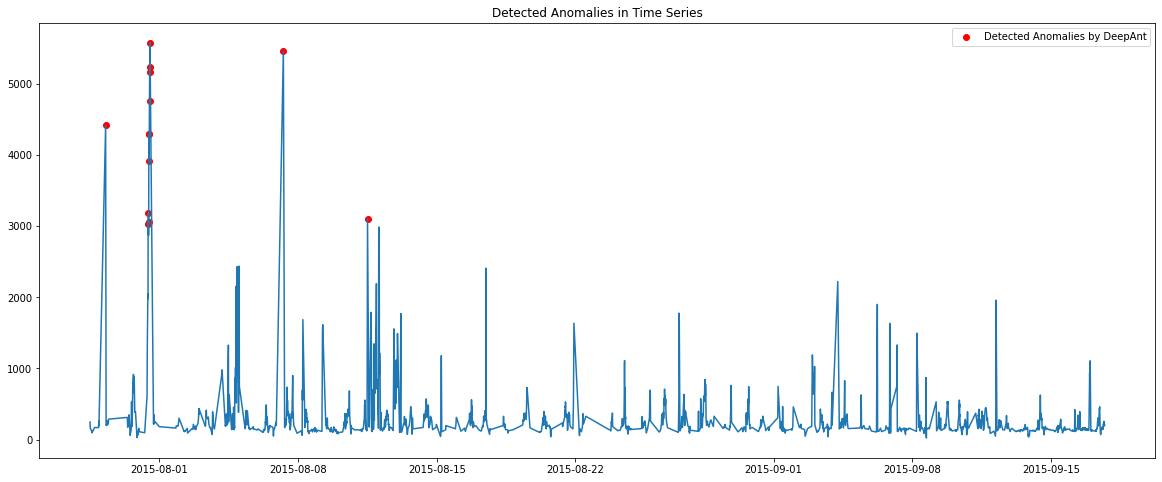

In [15]:
print('Anomalies Detected: ')
preds_losses.loc[lambda x: x > THRESHOLD]

ts_plot(df, preds_losses, THRESHOLD)